In [428]:
%matplotlib inline

In [429]:
import pandas as pd
import matplotlib.pyplot as plt

import re
import zipfile
import os

# Mental disorders analysis

## Introduction

## Plan
Although the project title is *Mental disorders analysis*, we are going to analize only a few like depression, anxiety and Obsessive Compulsive Disorder

Some words why I chose the datasets

At the beginning we are going to clean some datasets. Then we will proceed to make some hypotesis and prove or reject them. We are also going to compare results from multiple datasets.

Then we will try to train a model using Regression that will try to predict whether a person has any of the above mentioned disorders.

In the end, we will try to find typical behavior for those disorders and then compare it to other disorders.

## Data Cleanup

Let's begin by creating a function that will be used for renaming columns to *snake_case*

In [430]:
def to_snake_case(col_name):
    col_name = col_name.strip()
    col_name = col_name.lower()
    col_name = re.sub(r"[^\w\s]", "_", col_name) # replace non-alphanumeric characters with underscores
    col_name = re.sub(r"\s+", "_", col_name) # regex is used instead of replace to handle multiple spaces
    col_name = re.sub(r"_+", "_", col_name)  # replace multiple underscores with a single underscore
    col_name = col_name.rstrip("_")

    return col_name

Since one of the datasets is into a zip file and we want the notebook to be as reproducable as possible, we are going to create a function that extracts files from zips

In [431]:
def extract_zip(zip_path, extract_to):
    os.makedirs(extract_to, exist_ok=True)
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

Also, one of the datasets is a .xlsx format (Excel). We need a function to use it in .csv format.

In [498]:
def xlsx_to_csv(xlsx_path, csv_path):
    df = pd.read_excel(xlsx_path)
    df.to_csv(csv_path, index=False)

Because we will mostly work with numerical data, we need a way to represent categorical data as integers.

In [ ]:
# Handle Nominal and Ordinal and Binary Categorical Data functions

In [473]:
def binary_encode(df, column):
    df[column] = df[column].str.lower().map({'yes': 1, 'no': 0})
    return df

In [ ]:
def nominal_encode(df, column):
    pass

In [ ]:
def ordinal_encode(df, column):
    pass

### Student Depression

Let's start with the Student Depression Dataset.csv dataset.

In [474]:
student_depression_data = pd.read_csv('data/Student Depression Dataset.csv')

In [475]:
student_depression_data

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,140685,Female,27.0,Surat,Student,5.0,0.0,5.75,5.0,0.0,5-6 hours,Unhealthy,Class 12,Yes,7.0,1.0,Yes,0
27897,140686,Male,27.0,Ludhiana,Student,2.0,0.0,9.40,3.0,0.0,Less than 5 hours,Healthy,MSc,No,0.0,3.0,Yes,0
27898,140689,Male,31.0,Faridabad,Student,3.0,0.0,6.61,4.0,0.0,5-6 hours,Unhealthy,MD,No,12.0,2.0,No,0
27899,140690,Female,18.0,Ludhiana,Student,5.0,0.0,6.88,2.0,0.0,Less than 5 hours,Healthy,Class 12,Yes,10.0,5.0,No,1


In [476]:
student_depression_data.columns = [to_snake_case(c) for c in student_depression_data.columns]

First thing we notice is that the dataset contains a column named Profession. However, that column includes Student as a value. We also have Work/Study Hours.

In [477]:
profession_stats = student_depression_data.profession.value_counts()
profession_stats.columns = ["Profession", "Count"]
profession_stats

profession
Student                   27870
Architect                     8
Teacher                       6
Digital Marketer              3
Chef                          2
Content Writer                2
Pharmacist                    2
Doctor                        2
UX/UI Designer                1
Civil Engineer                1
Manager                       1
Educational Consultant        1
Lawyer                        1
Entrepreneur                  1
Name: count, dtype: int64

The bar chart says it all :)

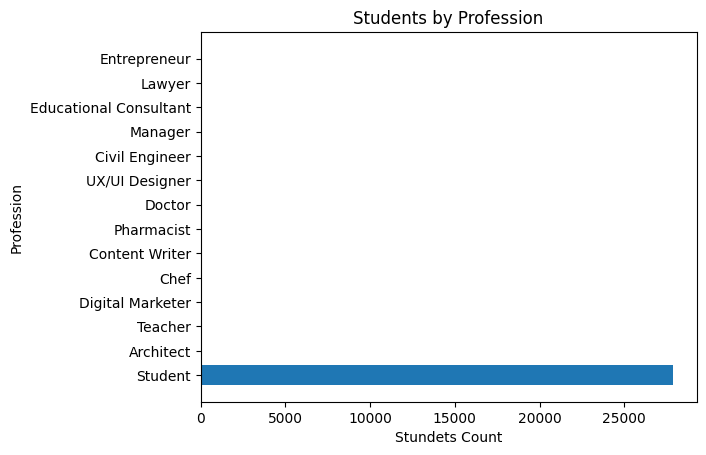

In [478]:
profession_stats = student_depression_data['profession'].value_counts()

professions = profession_stats.index
counts = profession_stats.values

plt.barh(professions, counts)
plt.title("Students by Profession")
plt.xlabel("Stundets Count")
plt.ylabel("Profession")

plt.show()

As the name of the dataset suggests, it is about student. Data also shows it by having too little of the ramaining values. That is why I am going to assume that any other profession is not usable for any hypothesis and any row that is not a student will be considered to be an outlier and therefore be removed.

In [479]:
student_depression_data = student_depression_data[student_depression_data.profession == "Student"]

Let's not forget to rename the Work/Study Hours (that now is work_study_hours) since it would not make sense otherwise

In [480]:
student_depression_data = student_depression_data.rename(columns={"work_study_hours": "study_hours"})

We can also see that there are very few students that have a value for the column Job Satisfaction. However, the profession is Student. These students could either be studying and working or only studying but since the value in the previously named column Work/Job Hours was in one place, I will assume that this data is redundant and could be deleted.

In [481]:
student_depression_data.job_satisfaction.value_counts()

job_satisfaction
0.0    27862
2.0        3
4.0        2
1.0        2
3.0        1
Name: count, dtype: int64

In [482]:
student_depression_data = student_depression_data[student_depression_data.job_satisfaction == 0]
student_depression_data = student_depression_data.drop(columns=["job_satisfaction"])

Here we can see that there are diferent values for Work Pressure and since we already decided to test only for students that are not employed, I am going to drop those that are equal to 0

In [483]:
student_depression_data.work_pressure.value_counts()

work_pressure
0.0    27862
Name: count, dtype: int64

In [484]:
student_depression_data = student_depression_data.drop(columns=["work_pressure"])

Since we removed all records where the Profession column has a value diferrent than Student we can remove the whole column since it does not bring any new knowledge

In [485]:
student_depression_data = student_depression_data.drop(columns=["profession"])

Now in order to be more consistent I will translate the values of the folowing columns to 0 and 1 instead of Yes or No:

Have you ever had suicidal thoughts ?
Family History of Mental Illness

And the gender column to:

Male = 0 and Female = 1

But let's first see if there are values that are not Yes or No and Male or Female.

I encode male and female as 0 and 1 because there aren't other values and I assume such won't be added

In [486]:
binary_encode(student_depression_data, "have_you_ever_had_suicidal_thoughts")
binary_encode(student_depression_data, "family_history_of_mental_illness")

student_depression_data.gender = (student_depression_data.gender == "Male").astype(int)

Finally, let's check if there are other than 1 and 0 in the depression column

In [487]:
student_depression_data.depression.value_counts()

depression
1    16304
0    11558
Name: count, dtype: int64

This is what the dataset looks after the cleanup

In [488]:
student_depression_data

,id,gender,age,city,academic_pressure,cgpa,study_satisfaction,sleep_duration,dietary_habits,degree,have_you_ever_had_suicidal_thoughts,study_hours,financial_stress,family_history_of_mental_illness,depression
0,2,1,33.0,Visakhapatnam,5.0,8.97,2.0,5-6 hours,Healthy,B.Pharm,1,3.0,1.0,0,1
1,8,0,24.0,Bangalore,2.0,5.90,5.0,5-6 hours,Moderate,BSc,0,3.0,2.0,1,0
2,26,1,31.0,Srinagar,3.0,7.03,5.0,Less than 5 hours,Healthy,BA,0,9.0,1.0,1,0
3,30,0,28.0,Varanasi,3.0,5.59,2.0,7-8 hours,Moderate,BCA,1,4.0,5.0,1,1
4,32,0,25.0,Jaipur,4.0,8.13,3.0,5-6 hours,Moderate,M.Tech,1,1.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,140685,0,27.0,Surat,5.0,5.75,5.0,5-6 hours,Unhealthy,Class 12,1,7.0,1.0,1,0
27897,140686,1,27.0,Ludhiana,2.0,9.40,3.0,Less than 5 hours,Healthy,MSc,0,0.0,3.0,1,0
27898,140689,1,31.0,Faridabad,3.0,6.61,4.0,5-6 hours,Unhealthy,MD,0,12.0,2.0,0,0
27899,140690,0,18.0,Ludhiana,5.0,6.88,2.0,Less than 5 hours,Healthy,Class 12,1,10.0,5.0,0,1


The dataset looks good. Let's now proceed with the second dataset about depression.

### Depression

In [466]:
extract_zip("data/depression_data.csv.zip", "data")
depression_data = pd.read_csv('data/depression_data.csv')

In [467]:
depression_data

,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No,Yes,Yes
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No,No,Yes
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,No,No,Yes,No
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,No,No,No,No
4,Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,Yes,No,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413763,Sean Miller,68,Married,Master's Degree,0,Former,Moderate,Employed,109233.43,Low,Healthy,Good,No,No,No,No
413764,Christina Brown,26,Single,Bachelor's Degree,0,Current,Active,Employed,96760.97,Low,Healthy,Poor,Yes,Yes,No,Yes
413765,Matthew Jenkins,57,Married,Bachelor's Degree,0,Non-smoker,Sedentary,Employed,77353.26,Moderate,Moderate,Fair,No,No,Yes,Yes
413766,Gary Faulkner,71,Married,Associate Degree,2,Non-smoker,Sedentary,Unemployed,24557.08,Moderate,Moderate,Poor,No,Yes,No,No


In [468]:
depression_data.columns = [to_snake_case(c) for c in depression_data.columns]

We can notice there are bunch of categorical values. Let's explore and convert them if needed

In [469]:
print("Nominal")
print(f"\tmarital_status => {depression_data.marital_status.unique()}")
print(f"\tsmoking_status => {depression_data.smoking_status.unique()}")
print(f"\temployment_status => {depression_data.employment_status.unique()}")
print("Ordinal")
print(f"\teducation_level => {depression_data.education_level.unique()}")
print(f"\tphysical_activity_level => {depression_data.physical_activity_level.unique()}")
print(f"\talcohol_consumption => {depression_data.alcohol_consumption.unique()}")
print(f"\tdietary_habits => {depression_data.dietary_habits.unique()}")
print(f"\tsleep_patterns => {depression_data.sleep_patterns.unique()}")
print("Binary")
print(f"\thistory_of_mental_illness => {depression_data.history_of_mental_illness.unique()}")
print(f"\thistory_of_substance_abuse => {depression_data.history_of_substance_abuse.unique()}")
print(f"\tfamily_history_of_depression => {depression_data.family_history_of_depression.unique()}")
print(f"\tchronic_medical_conditions => {depression_data.chronic_medical_conditions.unique()}")

Nominal
	marital_status => ['Married' 'Widowed' 'Divorced' 'Single']
	smoking_status => ['Non-smoker' 'Former' 'Current']
	employment_status => ['Unemployed' 'Employed']
Ordinal
	education_level => ["Bachelor's Degree" 'High School' "Master's Degree" 'Associate Degree'
 'PhD']
	physical_activity_level => ['Active' 'Sedentary' 'Moderate']
	alcohol_consumption => ['Moderate' 'High' 'Low']
	dietary_habits => ['Moderate' 'Unhealthy' 'Healthy']
	sleep_patterns => ['Fair' 'Good' 'Poor']
Binary
	history_of_mental_illness => ['Yes' 'No']
	history_of_substance_abuse => ['No' 'Yes']
	family_history_of_depression => ['Yes' 'No']
	chronic_medical_conditions => ['Yes' 'No']


Let's now check Yes or No columns and convert them to 1 and 0

In [470]:
print(f"history_of_mental_illness => {depression_data.history_of_mental_illness.unique()}")
print(f"history_of_substance_abuse => {depression_data.history_of_substance_abuse.unique()}")
print(f"family_history_of_depression => {depression_data.family_history_of_depression.unique()}")
print(f"chronic_medical_conditions => {depression_data.chronic_medical_conditions.unique()}")

history_of_mental_illness => ['Yes' 'No']
history_of_substance_abuse => ['No' 'Yes']
family_history_of_depression => ['Yes' 'No']
chronic_medical_conditions => ['Yes' 'No']


As we can see, *history_of_mental_illness*, *history_of_substance_abuse*, *family_history_of_depression* and *chronic_medical_conditions* contain Yes or No values which means we can convert them to 1 or 0

In [471]:
# todo: convert categorical values to numerical (ordinal and nominal)

In [472]:
binary_encode(depression_data, "history_of_mental_illness")
binary_encode(depression_data, "history_of_substance_abuse")
binary_encode(depression_data, "family_history_of_depression")
binary_encode(depression_data, "chronic_medical_conditions")

,name,age,marital_status,education_level,number_of_children,smoking_status,physical_activity_level,employment_status,income,alcohol_consumption,dietary_habits,sleep_patterns,history_of_mental_illness,history_of_substance_abuse,family_history_of_depression,chronic_medical_conditions
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,1,0,1,1
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,1,0,0,1
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,0,0,1,0
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,0,0,0,0
4,Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413763,Sean Miller,68,Married,Master's Degree,0,Former,Moderate,Employed,109233.43,Low,Healthy,Good,0,0,0,0
413764,Christina Brown,26,Single,Bachelor's Degree,0,Current,Active,Employed,96760.97,Low,Healthy,Poor,1,1,0,1
413765,Matthew Jenkins,57,Married,Bachelor's Degree,0,Non-smoker,Sedentary,Employed,77353.26,Moderate,Moderate,Fair,0,0,1,1
413766,Gary Faulkner,71,Married,Associate Degree,2,Non-smoker,Sedentary,Unemployed,24557.08,Moderate,Moderate,Poor,0,1,0,0


In [ ]:
# todo: convert ordinal

In [ ]:
# todo: convert nominal

Something about salary, age number_of_children, income

In [ ]:
depression_data

,name,age,marital_status,education_level,number_of_children,smoking_status,physical_activity_level,employment_status,income,alcohol_consumption,dietary_habits,sleep_patterns,history_of_mental_illness,history_of_substance_abuse,family_history_of_depression,chronic_medical_conditions
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,1,0,1,1
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,1,0,0,1
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,0,0,1,0
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,0,0,0,0
4,Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413763,Sean Miller,68,Married,Master's Degree,0,Former,Moderate,Employed,109233.43,Low,Healthy,Good,0,0,0,0
413764,Christina Brown,26,Single,Bachelor's Degree,0,Current,Active,Employed,96760.97,Low,Healthy,Poor,1,1,0,1
413765,Matthew Jenkins,57,Married,Bachelor's Degree,0,Non-smoker,Sedentary,Employed,77353.26,Moderate,Moderate,Fair,0,0,1,1
413766,Gary Faulkner,71,Married,Associate Degree,2,Non-smoker,Sedentary,Unemployed,24557.08,Moderate,Moderate,Poor,0,1,0,0


### Enhanced Anxiety

In [489]:
enhanced_anxiety_data = pd.read_csv('data/enhanced_anxiety_dataset.csv')

In [504]:
enhanced_anxiety_data

,age,gender,occupation,sleep_hours,physical_activity_hrs_week,caffeine_intake_mg_day,alcohol_consumption_drinks_week,smoking,family_history_of_anxiety,stress_level_1_10,heart_rate_bpm,breathing_rate_breaths_min,sweating_level_1_5,dizziness,medication,therapy_sessions_per_month,recent_major_life_event,diet_quality_1_10,anxiety_level_1_10
0,29,Female,Artist,6.0,2.7,181,10,Yes,No,10,114,14,4,No,Yes,3,Yes,7,5.0
1,46,Other,Nurse,6.2,5.7,200,8,Yes,Yes,1,62,23,2,Yes,No,2,No,8,3.0
2,64,Male,Other,5.0,3.7,117,4,No,Yes,1,91,28,3,No,No,1,Yes,1,1.0
3,20,Female,Scientist,5.8,2.8,360,6,Yes,No,4,86,17,3,No,No,0,No,1,2.0
4,49,Female,Other,8.2,2.3,247,4,Yes,No,1,98,19,4,Yes,Yes,1,No,3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10995,23,Female,Engineer,6.1,3.1,566,9,Yes,No,8,91,28,1,Yes,Yes,1,No,3,6.0
10996,50,Other,Teacher,6.6,3.6,64,17,Yes,No,7,95,17,3,No,No,2,No,7,3.0
10997,29,Male,Nurse,6.7,6.9,159,14,No,No,8,72,16,1,Yes,Yes,2,Yes,7,4.0
10998,53,Other,Artist,5.7,2.7,248,8,No,No,4,112,28,3,Yes,Yes,1,Yes,2,4.0


In [503]:
enhanced_anxiety_data.columns = [to_snake_case(c) for c in enhanced_anxiety_data.columns]

### Ocd Patient Dataset

In [505]:
ocd_patient_data = pd.read_csv('data/ocd_patient_dataset.csv')

In [508]:
ocd_patient_data

,patient_id,age,gender,ethnicity,marital_status,education_level,ocd_diagnosis_date,duration_of_symptoms_months,previous_diagnoses,family_history_of_ocd,obsession_type,compulsion_type,y_bocs_score_obsessions,y_bocs_score_compulsions,depression_diagnosis,anxiety_diagnosis,medications
0,1018,32,Female,African,Single,Some College,2016-07-15,203,MDD,No,Harm-related,Checking,17,10,Yes,Yes,SNRI
1,2406,69,Male,African,Divorced,Some College,2017-04-28,180,NaN,Yes,Harm-related,Washing,21,25,Yes,Yes,SSRI
2,1188,57,Male,Hispanic,Divorced,College Degree,2018-02-02,173,MDD,No,Contamination,Checking,3,4,No,No,Benzodiazepine
3,6200,27,Female,Hispanic,Married,College Degree,2014-08-25,126,PTSD,Yes,Symmetry,Washing,14,28,Yes,Yes,SSRI
4,5824,56,Female,Hispanic,Married,High School,2022-02-20,168,PTSD,Yes,Hoarding,Ordering,39,18,No,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,5374,38,Male,Hispanic,Divorced,College Degree,2019-01-10,53,MDD,No,Contamination,Washing,21,33,Yes,Yes,SSRI
1496,5013,19,Female,Hispanic,Divorced,Graduate Degree,2022-09-14,160,GAD,Yes,Hoarding,Praying,25,16,Yes,Yes,SSRI
1497,6089,40,Male,Asian,Married,Some College,2018-03-13,100,NaN,Yes,Contamination,Counting,2,15,Yes,Yes,Benzodiazepine
1498,3808,37,Female,Caucasian,Married,Some College,2018-04-14,210,GAD,Yes,Contamination,Washing,16,7,Yes,No,Benzodiazepine


In [507]:
ocd_patient_data.columns = [to_snake_case(c) for c in ocd_patient_data.columns]

### Mental Disorder Symptoms

In [499]:
xlsx_to_csv("data/Mental disorder symptoms.xlsx", "data/Mental disorder symptoms.csv")
mental_disorder_data = pd.read_csv('data/depression_data.csv')

In [502]:
mental_disorder_data

,name,age,marital_status,education_level,number_of_children,smoking_status,physical_activity_level,employment_status,income,alcohol_consumption,dietary_habits,sleep_patterns,history_of_mental_illness,history_of_substance_abuse,family_history_of_depression,chronic_medical_conditions
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No,Yes,Yes
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No,No,Yes
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,No,No,Yes,No
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,No,No,No,No
4,Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,Yes,No,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413763,Sean Miller,68,Married,Master's Degree,0,Former,Moderate,Employed,109233.43,Low,Healthy,Good,No,No,No,No
413764,Christina Brown,26,Single,Bachelor's Degree,0,Current,Active,Employed,96760.97,Low,Healthy,Poor,Yes,Yes,No,Yes
413765,Matthew Jenkins,57,Married,Bachelor's Degree,0,Non-smoker,Sedentary,Employed,77353.26,Moderate,Moderate,Fair,No,No,Yes,Yes
413766,Gary Faulkner,71,Married,Associate Degree,2,Non-smoker,Sedentary,Unemployed,24557.08,Moderate,Moderate,Poor,No,Yes,No,No


In [501]:
mental_disorder_data.columns = [to_snake_case(c) for c in mental_disorder_data.columns]

## Some hypothesis

### Hypothesis 01

### Hypothesis 02

### Hypothesis 03

### Hypothesis ...

### Hypothesis N

## Some more serious data science (Regression maybe)

## Comparing behaviours in disorders

## Sources

[Student Depression Dataset.](https://www.kaggle.com/datasets/hopesb/student-depression-dataset)

[Depression Dataset](https://www.kaggle.com/datasets/anthonytherrien/depression-dataset)

[Social Anxiety Dataset](https://www.kaggle.com/datasets/natezhang123/social-anxiety-dataset/data)

[Anxiety and Depression Mental Health Factors](https://www.kaggle.com/datasets/ak0212/anxiety-and-depression-mental-health-factors)

[OCD Patient Dataset: Demographics & Clinical Data](https://www.kaggle.com/datasets/ohinhaque/ocd-patient-dataset-demographics-and-clinical-data)

[OCD_Social_Media_Dataset](https://www.kaggle.com/datasets/bhagvendersingh/ocd-social-media-dataset)

[Mental Disorders Dataset](https://www.kaggle.com/datasets/baselbakeer/mental-disorders-dataset/data)